In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from functools import reduce
from pyspark.sql import DataFrame
from pyspark.sql import functions as F
from pyspark import SparkFiles
import numpy as np

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
6,application_1670220916827_0009,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
sc = SparkSession.builder.getOrCreate()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Install Tensorflow if not installed

In [4]:
# %pip install tensorflow

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
%local
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

# Read Data From S3

In [7]:
%%local
df_user = pd.read_csv("s3://fnzoton-gbs/rating_preprocessed.csv")
user_ids = df_user["ID"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
book_ids = df_user["Name"].unique().tolist()
book2book_encoded = {x: i for i, x in enumerate(book_ids)}
book_encoded2book = {i: x for i, x in enumerate(book_ids)}
df_user["user"] = df_user["ID"].map(user2user_encoded)
df_user["book"] = df_user["Name"].map(book2book_encoded)

df_user = df_user.drop("Index",axis=1)
num_users = len(df_user["User"].unique())
num_books = len(df_user["Book"].unique())
num_users, num_books

(4118, 102744)

# Create Recommeder Neural Net

In [8]:
%local
EMBEDDING_SIZE = 50
class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_books, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_books = num_books
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.book_embedding = layers.Embedding(
            num_books,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.book_bias = layers.Embedding(num_books, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        book_vector = self.book_embedding(inputs[:, 1])
        book_bias = self.book_bias(inputs[:, 1])
        dot_user_book = tf.tensordot(user_vector, book_vector, 2)
        # Add all the components (including bias)
        x = dot_user_book + user_bias + book_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_books, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
)

# Prepared Dataset

In [9]:
%local
min_rating = min(df_user["Scores"])
max_rating = max(df_user["Scores"])

df_user = df_user.sample(frac=1, random_state=42)
x = df_user[["User", "Book"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df_user["Scores"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df_user.shape[0])
x_train, x_val, y_train, y_val = (x[:train_indices],x[train_indices:],y[:train_indices], y[train_indices:])

# Train Model

In [10]:
%local 
history = model.fit(x=x_train, y=y_train, batch_size=64, epochs=5, verbose=1, validation_data=(x_val, y_val))

Epoch 1/5
4818/4818 [==============================] - 196s 41ms/step - loss: 0.3764 - val_loss: 0.3242
Epoch 2/5
4818/4818 [==============================] - 188s 39ms/step - loss: 0.3169 - val_loss: 0.3202
Epoch 3/5
4818/4818 [==============================] - 190s 39ms/step - loss: 0.3103 - val_loss: 0.3159
Epoch 4/5
4818/4818 [==============================] - 189s 39ms/step - loss: 0.3057 - val_loss: 0.3159
Epoch 5/5
4818/4818 [==============================] - 184s 38ms/step - loss: 0.3043 - val_loss: 0.3206


# Plot Training and Validation Loss

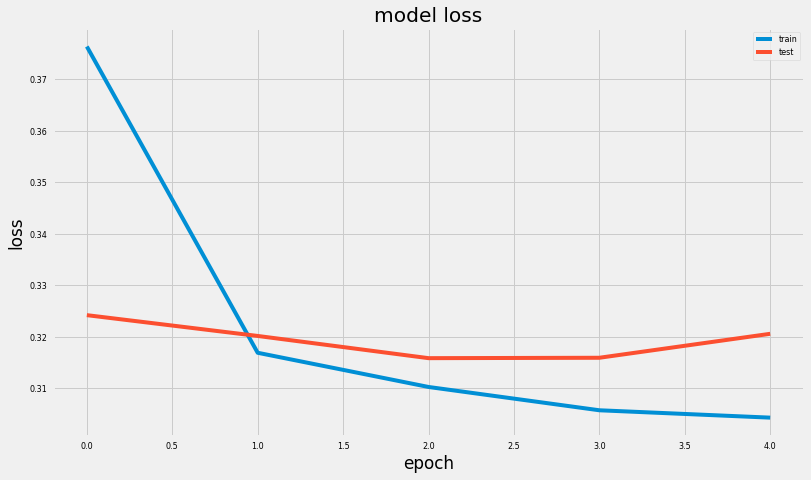

In [21]:
%local
plt.figure(figsize=(12,7))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper right")
plt.show()

# Generate Top 10 Book Recommendation Predictions
## Prediction 1

In [41]:
%local
user_id = df_user.ID.sample(1).iloc[0]
book_read_by_user = df_user[df_user.ID == user_id]
book_not_read = df_user[~df_user.Name.isin(book_read_by_user.Name)]["book"].unique()
x_test = np.array([[user_id]*len(book_not_read),book_not_read]).T
predictions = model.predict(x_test)

x_test_ypred = np.concatenate((x_test,predictions),axis=1)
top_10_books = x_test_ypred[(-x_test_ypred[:,2]).argsort()][:10,1]
print("=============TOP  10 RECOMMENDED BOOK================")
for bookId in top_10_books:
    print(book_encoded2book.get(bookId))
    
print("=============TOP  5 BOOKS READ BY USER================")
top_5_books = book_read_by_user.sort_values("Scores",ascending=False)["Name"][:5].to_list()
for book in top_5_books:
    print(book)

3205/3205 [==============================] - 3s 844us/step
=============TOP  10 RECOMMENDED BOOK================
Becoming
The BFG
Binti (Binti, #1)
Zeitoun
رباعيات خيام
Maus II: A Survivor's Tale: And Here My Troubles Began (Maus, #2)
The Cider House Rules
There There
Hyperion (Hyperion Cantos, #1)
The Martian
=============TOP  5 BOOKS READ BY USER================
The Book Thief
Good Night Stories for Rebel Girls: 100 Tales of Extraordinary Women
The Big Book of Birth
Pride and Prejudice
Catching Fire (The Hunger Games, #2)


## Prediction 2

In [29]:
%local
user_id = df_user.ID.sample(1).iloc[0]
book_read_by_user = df_user[df_user.ID == user_id]
book_not_read = df_user[~df_user.Name.isin(book_read_by_user.Name)]["book"].unique()
x_test = np.array([[user_id]*len(book_not_read),book_not_read]).T
predictions = model.predict(x_test)

x_test_ypred = np.concatenate((x_test,predictions),axis=1)
top_10_books = x_test_ypred[(-x_test_ypred[:,2]).argsort()][:10,1]
print("=============TOP  10 RECOMMENDED BOOK================")
for bookId in top_10_books:
    print(book_encoded2book.get(bookId))
    
print("=============TOP  5 BOOKS READ BY USER================")
top_5_books = book_read_by_user.sort_values("Scores",ascending=False)["Name"][:5].to_list()
for book in top_5_books:
    print(book)

3198/3198 [==============================] - 3s 830us/step
=============TOP  10 RECOMMENDED BOOK================
Between the World and Me
Becoming
Pachinko
Maus II: A Survivor's Tale: And Here My Troubles Began (Maus, #2)
The Things They Carried
Maus I: A Survivor's Tale: My Father Bleeds History (Maus, #1)
Commonwealth
The Lord of the Rings (The Lord of the Rings, #1-3)
The Nickel Boys
The Nightingale
=============TOP  5 BOOKS READ BY USER================
The Girl Who Played with Fire (Millennium, #2)
Jitterbug Perfume
Blood Red Road (Dust Lands, #1)
The Dovekeepers
Fever Pitch


# Prediction 3

In [42]:
%local
user_id = df_user.ID.sample(1).iloc[0]
book_read_by_user = df_user[df_user.ID == user_id]
book_not_read = df_user[~df_user.Name.isin(book_read_by_user.Name)]["book"].unique()
x_test = np.array([[user_id]*len(book_not_read),book_not_read]).T
predictions = model.predict(x_test)

x_test_ypred = np.concatenate((x_test,predictions),axis=1)
top_10_books = x_test_ypred[(-x_test_ypred[:,2]).argsort()][:10,1]
print("=============TOP  10 RECOMMENDED BOOK================")
for bookId in top_10_books:
    print(book_encoded2book.get(bookId))
    
print("=============TOP  5 BOOKS READ BY USER================")
top_5_books = book_read_by_user.sort_values("Scores",ascending=False)["Name"][:5].to_list()
for book in top_5_books:
    print(book)

3210/3210 [==============================] - 3s 803us/step
=============TOP  10 RECOMMENDED BOOK================
Between the World and Me
The Lord of the Rings (The Lord of the Rings, #1-3)
Becoming
The Nightingale
The BFG
Zeitoun
Pachinko
When Breath Becomes Air
Wonder (Wonder, #1)
The Things They Carried
=============TOP  5 BOOKS READ BY USER================
One Hundred Years of Solitude
Jude the Obscure
Far from the Madding Crowd
A Soldier of the Great War
The House of the Spirits
